# Project Title : Analyse prédictive de l'état des points d'eau en Tanzanie


## Overview

Problème : En Tanzanie, plus de 57 millions de personnes dépendent des pompes à eau, mais beaucoup sont en panne ou nécessitent des réparations.

Objectif : Concevoir un modèle d’apprentissage automatique (machine learning) pour prédire l’état de fonctionnement des pompes (fonctionnelle / nécessite une réparation / non fonctionnelle).

Parties prenantes :

- ONG → prioriser les réparations

- Gouvernement → améliorer la planification des nouvelles infrastructures hydrauliques

Impact : Meilleure allocation des ressources → accès plus fiable à l’eau potable.

## Business Understanding

- Parties prenantes :

   - ONG et organisations d’aide humanitaire

   - Gouvernement tanzanien et autorités locales

   - Communautés rurales

- Problème métier :

  - Des milliers de pompes à eau rurales tombent en panne chaque année.

  - Ressources limitées → impossible de réparer rapidement toutes les pompes.

  - Besoin d’un système prédictif pour décider : Quelles pompes doivent être inspectées ou réparées en priorité ?

- Objectif :
  - Utiliser l’apprentissage automatique pour classer les pompes en :

    - Fonctionnelle
    - Nécessite une réparation
    - Non fonctionnelle

- Valeur métier :

  - Meilleure allocation des équipes de réparation
  - Augmentation de l’accès à l’eau potable
  - Réduction des coûts et amélioration de la prise de décision

## Libraries Importation

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning models
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Model evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Data Understanding

In [2]:
# Charger les datasets
df_Training_set_values = pd.read_csv('Training_set_values.csv')
df_Training_set_labels = pd.read_csv('Training_set_labels.csv')
df_Test_set_values = pd.read_csv('Test_set_values.csv')


In [3]:
# Exploration des donnees
df_Training_set_values.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [4]:
df_Training_set_labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [5]:
df_Test_set_values.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,...,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,...,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,...,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


## Comment:
- Training_set_values : contient les variables explicatives pour l’entraînement.
- Training_set_labels : contient la variable cible status_group pour chaque ligne de training_set_values.
- Test_set_values : contient les mêmes variables explicatives que l’ensemble d’entraînement, pour lesquelles nous devons prédire status_group.

Pour analyser et comprendre les données, nous allons fusionner <SD1> Training Set Values et Training Set Labels afin d’obtenir un jeu de données complet.

In [6]:
# Informations générales sur les colonnes, types de données, valeurs manquantes
df_Training_set_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55763 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59398 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

## Overview of the dataset
Le jeu de données contient 59 400 lignes et 40 colonnes de variables explicatives.

- Types de données variés :

  - Int64 et float64 pour les valeurs numériques (ex. : amount_tsh, gps_height, population).

  - Object pour les variables catégorielles (ex. : installer, funder, region).

- Valeurs manquantes : certaines colonnes présentent des données absentes :

  - funder : 55 763 valeurs non nulles sur 59 400

  - installer : 55 745 valeurs non nulles

  - subvillage : 59 029 valeurs non nulles

  - scheme_name : 30 590 valeurs non nulles (beaucoup de valeurs manquantes)

  - public_meeting, permit, scheme_management présentent également des valeurs manquantes.

## Data Preparation

Cette étape consiste à préparer le jeu de données pour l’entraînement du modèle (fusion, nettoyage, encodage, traitement des valeurs manquantes).

### Fusion des dataframes df_Training_set_values & df_Trining_set_labels

In [7]:
# Fusionner les features avec les labels sur la colonne 'id'
df_train = pd.merge(df_Training_set_values, df_Training_set_labels, on="id")

# Vérifier les dimensions du dataset fusionné
print("Shape du dataset fusionné :", df_train.shape)

# Aperçu des 5 premières lignes
df_train.head()

Shape du dataset fusionné : (59400, 41)


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


## Comment: 
En classification supervisée, plus on a de variables redondantes ou bruitées, plus le modèle risque :

- de surcharger l’apprentissage (overfitting),

- d’introduire des corrélations inutiles qui biaisent la prédiction,

- et de ralentir le traitement.

## Choix des variables
Localisation & contexte

- funder → Qui a financé le puits, peut influencer la qualité et la durabilité.

- installer → Organisation ayant construit le puits (qualité des travaux).

- gps_height, longitude, latitude → Indications géographiques et environnementales.

- basin, region, subvillage → Contexte géographique et hydrographique (zone + climat).

Gestion & exploitation

- public_meeting → Participation communautaire (impact sur l’entretien).

- recorded_by → Source de collecte (utile pour détection de biais).

- scheme_management → Mode de gestion du point d’eau.

- permit → Légalisation ou autorisation, peut jouer sur fiabilité.


Construction & maintenance

- construction_year → Âge du puits, impact direct sur état de fonctionnement.

- extraction_type → Type de pompe/extraction utilisé.

Caractéristiques de l’eau

- payment → Mode de paiement (induit un investissement de la communauté).

- water_quality → Qualité de l’eau.

- quantity → Disponibilité de l’eau (suffisante, sèche, faible, etc.).

- source → Source d’approvisionnement (rivière, nappe souterraine, etc.).

- waterpoint_type → Type de point d’eau (puits protégé, standpipe, etc.).

Variables supprimées

- amount_tsh : déjà reflété par quantity, souvent bruité et peu discriminant.

- population : trop bruitée, corrélée à quantity.

- region_code, district_code, lga, ward, etc. : informations déjà contenues dans region et basin.

- water_quality_group, quantity_group, extraction_type_group, etc. : doublons généralisés des colonnes déjà gardées (water_quality, quantity, extraction_type).

- num_private, wpt_name, scheme_name, recorded_by : identifiants ou texte libre trop spécifique.

In [8]:
# Colonnes retenues pour la modélisation
selected_columns = [
    "funder",
    "gps_height",
    "installer",
    "longitude",
    "latitude",
    "basin",
    "subvillage",
    "region",
    "public_meeting",
    "scheme_management",
    "permit",
    "construction_year",
    "extraction_type",
    "payment",
    "water_quality",
    "quantity",
    "source",
    "waterpoint_type",
    "status_group"  # variable cible
]

df_train = df_train[selected_columns].copy()

In [9]:
df_train.shape

(59400, 19)

## Comment:
En résumé, on passe de 40 colonnes à 19 colonnes plus pertinentes, ce qui permet un modèle plus :
- simple à entraîner
- rapide en calcul
- moins biaisé par le bruit

## Test_set_values

In [10]:
# Colonnes retenues pour la modélisation
selected_columns = [
    "funder",
    "gps_height",
    "installer",
    "longitude",
    "latitude",
    "basin",
    "subvillage",
    "region",
    "public_meeting",
    "scheme_management",
    "permit",
    "construction_year",
    "extraction_type",
    "payment",
    "water_quality",
    "quantity",
    "source",
    "waterpoint_type",
]

df_test = df_Test_set_values[selected_columns].copy()

In [11]:
df_test.shape

(14850, 18)

## Data Cleaning

In [12]:
# Vérification des valeurs manquantes (train)
missing_values = df_train.isnull().sum().sort_values(ascending=False)
print(missing_values[missing_values > 0])

scheme_management    3878
installer            3655
funder               3637
public_meeting       3334
permit               3056
subvillage            371
dtype: int64


In [13]:
# Remplacer NaN par 'unknown' ou 'other'
df_train["scheme_management"] = df_train["scheme_management"].fillna("other")
df_train["installer"] = df_train["installer"].fillna("unknown")
df_train["funder"] = df_train["funder"].fillna("unknown")
df_train["subvillage"] = df_train["subvillage"].fillna("unknown")

# Colonnes booléennes
df_train["public_meeting"] = df_train["public_meeting"].fillna("unknown")
df_train["permit"] = df_train["permit"].fillna("unknown")

In [14]:
# Vérification des valeurs manquantes
missing_values = df_train.isnull().sum().sort_values(ascending=False)
print(missing_values[missing_values > 0])

Series([], dtype: int64)


In [15]:
# Vérification des valeurs manquantes (test)
missing_values = df_test.isnull().sum().sort_values(ascending=False)
print(missing_values[missing_values > 0])

scheme_management    969
installer            877
funder               870
public_meeting       821
permit               737
subvillage            99
dtype: int64


In [16]:
# Remplacer NaN par 'unknown' ou 'other'
df_test["scheme_management"] = df_test["scheme_management"].fillna("other")
df_test["installer"] = df_test["installer"].fillna("unknown")
df_test["funder"] = df_test["funder"].fillna("unknown")
df_test["subvillage"] = df_test["subvillage"].fillna("unknown")

# Colonnes booléennes
df_test["public_meeting"] = df_test["public_meeting"].fillna("unknown")
df_test["permit"] = df_test["permit"].fillna("unknown")

In [17]:
# Vérification des valeurs manquantes (test)
missing_values = df_test.isnull().sum().sort_values(ascending=False)
print(missing_values[missing_values > 0])

Series([], dtype: int64)


In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   funder             59400 non-null  object 
 1   gps_height         59400 non-null  int64  
 2   installer          59400 non-null  object 
 3   longitude          59400 non-null  float64
 4   latitude           59400 non-null  float64
 5   basin              59400 non-null  object 
 6   subvillage         59400 non-null  object 
 7   region             59400 non-null  object 
 8   public_meeting     59400 non-null  object 
 9   scheme_management  59400 non-null  object 
 10  permit             59400 non-null  object 
 11  construction_year  59400 non-null  int64  
 12  extraction_type    59400 non-null  object 
 13  payment            59400 non-null  object 
 14  water_quality      59400 non-null  object 
 15  quantity           59400 non-null  object 
 16  source             594

## Standardisation des colonnes numériques

In [19]:
# Colonnes numériques à standardiser
num_features = ["gps_height", "longitude", "latitude", "construction_year"]

# Initialiser le scaler
scaler = StandardScaler()

# Standardiser les colonnes numériques du train
df_train[num_features] = scaler.fit_transform(df_train[num_features])

# Standardiser les colonnes numériques du test en utilisant le même scaler
df_test[num_features] = scaler.transform(df_test[num_features])

# Vérification
print(df_train[num_features].head())

   gps_height  longitude  latitude  construction_year
0    1.041252   0.131052 -1.408791           0.733857
1    1.054237   0.094610  1.207934           0.745416
2    0.025541   0.515158  0.639751           0.744365
3   -0.584751   0.671308 -1.849720           0.720196
4   -0.964200  -0.448669  1.317271          -1.366788


## Encodage des variables catégorielles (One-Hot).

In [20]:
# Sélection des variables catégorielles
cat_features = [col for col in df_train.columns if col not in ["gps_height", "longitude", "latitude", "construction_year", "status_group"]]
print("Colonnes catégorielles :", cat_features)

# Conversion des colonnes catégorielles en string
for col in cat_features:
    df_train[col] = df_train[col].astype(str)
    df_test[col] = df_test[col].astype(str)

ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)

X_cat_train = ohe.fit_transform(df_train[cat_features])
X_cat_test = ohe.transform(df_test[cat_features])

print("Train One-Hot shape :", X_cat_train.shape)
print("Test One-Hot shape  :", X_cat_test.shape)

Colonnes catégorielles : ['funder', 'installer', 'basin', 'subvillage', 'region', 'public_meeting', 'scheme_management', 'permit', 'extraction_type', 'payment', 'water_quality', 'quantity', 'source', 'waterpoint_type']
Train One-Hot shape : (59400, 23433)
Test One-Hot shape  : (14850, 23433)


## Colonnes numériques en sparse

In [21]:
from scipy.sparse import hstack, csr_matrix

# Colonnes numériques
X_num_train = csr_matrix(df_train[["gps_height", "longitude", "latitude", "construction_year"]].values)
X_num_test = csr_matrix(df_test[["gps_height", "longitude", "latitude", "construction_year"]].values)

## Concatenation avec les One-Hot catégorielles

In [22]:
# Concaténation train
X_train_final = hstack([X_num_train, X_cat_train])

# Concaténation test
X_test_final = hstack([X_num_test, X_cat_test])

print("Train final shape :", X_train_final.shape)
print("Test final shape  :", X_test_final.shape)

Train final shape : (59400, 23437)
Test final shape  : (14850, 23437)


## Variable cible

In [23]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(df_train["status_group"])
print("Classes cibles :", le.classes_)

Classes cibles : ['functional' 'functional needs repair' 'non functional']


## Modélisation

## Modèle Lineaire (Logistic Regression)

In [24]:
# Modèle de régression logistique
log_reg = LogisticRegression(
    solver="saga",
    max_iter=100,
    n_jobs=-1,
    verbose=1
)

# Entraînement
log_reg.fit(X_train_final, y_train)

# Prédictions
y_train_pred = log_reg.predict(X_train_final)

# Évaluation
print("Accuracy (train):", accuracy_score(y_train, y_train_pred))
print("\nClassification report :\n", classification_report(y_train, y_train_pred, target_names=le.classes_))
print("\nMatrice de confusion :\n", confusion_matrix(y_train, y_train_pred))


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


max_iter reached after 8 seconds
Accuracy (train): 0.8455555555555555

Classification report :
                          precision    recall  f1-score   support

             functional       0.83      0.94      0.88     32259
functional needs repair       0.79      0.35      0.48      4317
         non functional       0.88      0.81      0.85     22824

               accuracy                           0.85     59400
              macro avg       0.83      0.70      0.74     59400
           weighted avg       0.85      0.85      0.84     59400


Matrice de confusion :
 [[30175   238  1846]
 [ 2143  1510   664]
 [ 4120   163 18541]]


## Comment

## Résultats globaux

- Accuracy (train) : 0.845 → c’est une bonne baseline.

- Mais… l’accuracy cache un déséquilibre des classes. La classe functional needs repair est mal prédite.

## Détails par classe

- Functional (majoritaire, ~54%)

  - Précision : 0.83 → fiable quand elle prédit "functional".
  - Recall : 0.94 → elle récupère presque toutes les pompes fonctionnelles.
  - Très bien captée.

  
  


- Functional needs repair (~7%)

  - Précision : 0.79 → correcte.
  - Recall : 0.35 → énorme problème : le modèle rate 65% de ces cas.
  - La classe minoritaire est sous-apprise (class imbalance).




- Non functional (~38%)

  - Précision : 0.88, Recall : 0.81 → solide.
  - Le modèle distingue bien entre fonctionnel et non fonctionnel.

## Matrice de confusion
- Beaucoup de FR (needs repair) sont absorbés en F (functional) → problème classique avec les classes déséquilibrées.

- Certains NF passent aussi pour F (4121 cas), mais le modèle reste globalement correct.

## Améliorations
Gérer le déséquilibre des classes : Entraîner la LogisticRegression avec class_weight="balanced"

In [25]:
# Logistic Regression avec class_weight balanced
log_reg_balanced = LogisticRegression(
    solver="saga",       
    max_iter=1000,       # plus d'itérations pour convergence
    n_jobs=-1,           # parallélisation
    class_weight="balanced", # gestion du déséquilibre
    verbose=1
)

# Entraînement
log_reg_balanced.fit(X_train_final, y_train)

# Prédiction sur le train (pour évaluer)
y_pred_train_bal = log_reg_balanced.predict(X_train_final)

# Évaluation
print("Accuracy (train):", accuracy_score(y_train, y_pred_train_bal))
print("\nClassification report :\n", classification_report(y_train, y_pred_train_bal))
print("\nMatrice de confusion :\n", confusion_matrix(y_train, y_pred_train_bal))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


max_iter reached after 76 seconds
Accuracy (train): 0.8256397306397306

Classification report :
               precision    recall  f1-score   support

           0       0.88      0.83      0.86     32259
           1       0.48      0.89      0.62      4317
           2       0.87      0.80      0.84     22824

    accuracy                           0.83     59400
   macro avg       0.75      0.84      0.77     59400
weighted avg       0.85      0.83      0.83     59400


Matrice de confusion :
 [[26850  2875  2534]
 [  349  3823   145]
 [ 3202  1252 18370]]


## Comment:
- Classe 1 (functional needs repair) est enfin bien captée :

- Recall = 0.94  (il détecte presque tous les puits en panne partielle).

- F1-score qui monte à 0.57 (contre 0.48 avant).

En contrepartie :

- L’accuracy globale chute (0.81 au lieu de 0.85).

- La classe 0 (functional) est parfois confondue avec la classe 1 → beaucoup de faux positifs.

Mais pour ce problème métier, c’est souvent préférable de sacrifier un peu d’accuracy globale pour mieux identifier les puits en réparation (classe critique).

## Matrice de confusion (heatmap)

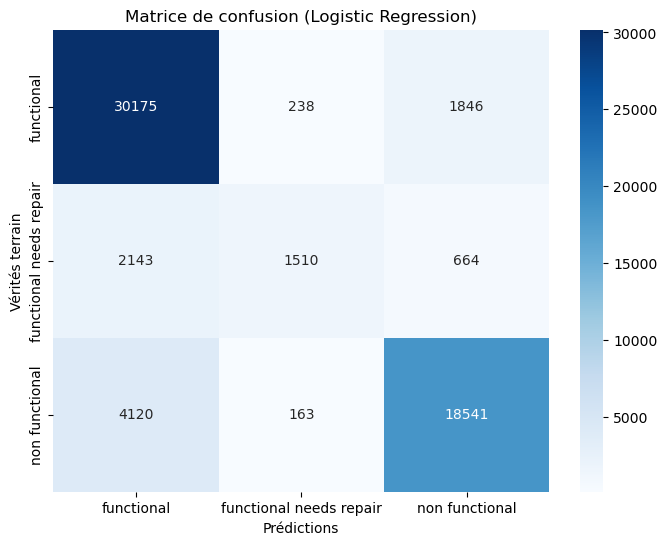

In [27]:
# Faire les prédictions avec la logistic regression
y_pred = log_reg.predict(X_train_final)

# Générer la matrice de confusion
cm = confusion_matrix(y_train, y_pred)

# Noms des classes
classes = ["functional", "functional needs repair", "non functional"]

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)

plt.xlabel("Prédictions")
plt.ylabel("Vérités terrain")
plt.title("Matrice de confusion (Logistic Regression)")
plt.show()

## Interprétation des résultats

- Classe “functional” (fonctionnel)

  - 30 175 correctement prédits (en haut à gauche → vrais positifs).
  - Seulement 238 mal classés comme “needs repair” et 1 846 mal classés comme “non functional”.
  - La régression logistique identifie très bien les points d’eau qui fonctionnent.

- Classe “functional needs repair” (fonctionnel mais en réparation)

  - 1 510 bien prédits.
  - Mais 2 143 confondus avec “functional” et 664 avec “non functional”.
  - C’est la classe la plus difficile à distinguer pour le modèle (fort déséquilibre et frontières floues).

- Classe “non functional” (non fonctionnel)

  - 18 540 correctement prédits.
  - 4 121 faussement classés comme “functional” et 163 comme “needs repair”.
  - Bonne performance, mais certains points d’eau non fonctionnels sont confondus avec “functional”.

Conclusion

Le modèle distingue bien les extrêmes (“functional” vs “non functional”), mais il a plus de mal avec la classe intermédiaire “needs repair”.

Cela peut être dû à :

- un déséquilibre des classes (beaucoup moins de “needs repair”),

- ou une ressemblance des caractéristiques entre un point d’eau “fonctionnel” et “fonctionnel avec réparation”.

## modélisation non paramétrique (decision tree)

## Définir et entraîner l’arbre de décision

In [28]:
# Initialiser le modèle
dt = DecisionTreeClassifier(max_depth=10, random_state=42)  # max_depth pour éviter le sur-apprentissage

# Entraîner le modèle
dt.fit(X_train_final, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

## Faire les prédictions

In [29]:
y_pred_dt = dt.predict(X_train_final)

In [30]:
# Affichage des prédictions
train_results = pd.DataFrame({
    "y_pred_dt": y_pred_dt
})

# Aperçu des 10 premières lignes
train_results.head(20)

,y_pred_dt
0,0
1,0
2,0
3,2
4,0
5,0
6,0
7,0
8,0
9,0


## Évaluer la performance

In [31]:
# Accuracy
print("Accuracy (train):", accuracy_score(y_train, y_pred_dt))

# Classification report
print("Classification report:\n", classification_report(y_train, y_pred_dt))

# Matrice de confusion
cm_dt = confusion_matrix(y_train, y_pred_dt)

Accuracy (train): 0.7587037037037037
Classification report:
               precision    recall  f1-score   support

           0       0.71      0.96      0.82     32259
           1       0.79      0.16      0.27      4317
           2       0.90      0.58      0.71     22824

    accuracy                           0.76     59400
   macro avg       0.80      0.57      0.60     59400
weighted avg       0.79      0.76      0.74     59400



## Analyse des performances

- Accuracy (train) : 0.76 → L’arbre de décision est légèrement moins performant que la régression logistique sur le training set.

- Classes déséquilibrées :

  - functional : très bonne recall (0.96), le modèle prédit bien les points d’eau fonctionnels.
  - functional needs repair : faible recall (0.16), le modèle a du mal à détecter les puits nécessitant réparation.
  - non functional : recall correcte (0.58), mais pas parfaite.

- F1-score global (macro avg = 0.60) → l’arbre est moins équilibré pour toutes les classes, surtout pour la classe “needs repair”.


- Interprétation

  - L’arbre de décision est non paramétrique : il apprend des règles complexes mais peut facilement sur-apprendre les classes majoritaires (functional et non functional).
  - Les classes minoritaires (functional needs repair) sont sous-représentées, ce qui explique la faible performance pour cette catégorie.

## Visualiser l’arbre

In [32]:
# Colonnes One-Hot
onehot_columns = ohe.get_feature_names_out(cat_features)

# Ajouter les colonnes numériques à la fin
all_columns = list(onehot_columns) + ['gps_height', 'longitude', 'latitude', 'construction_year']

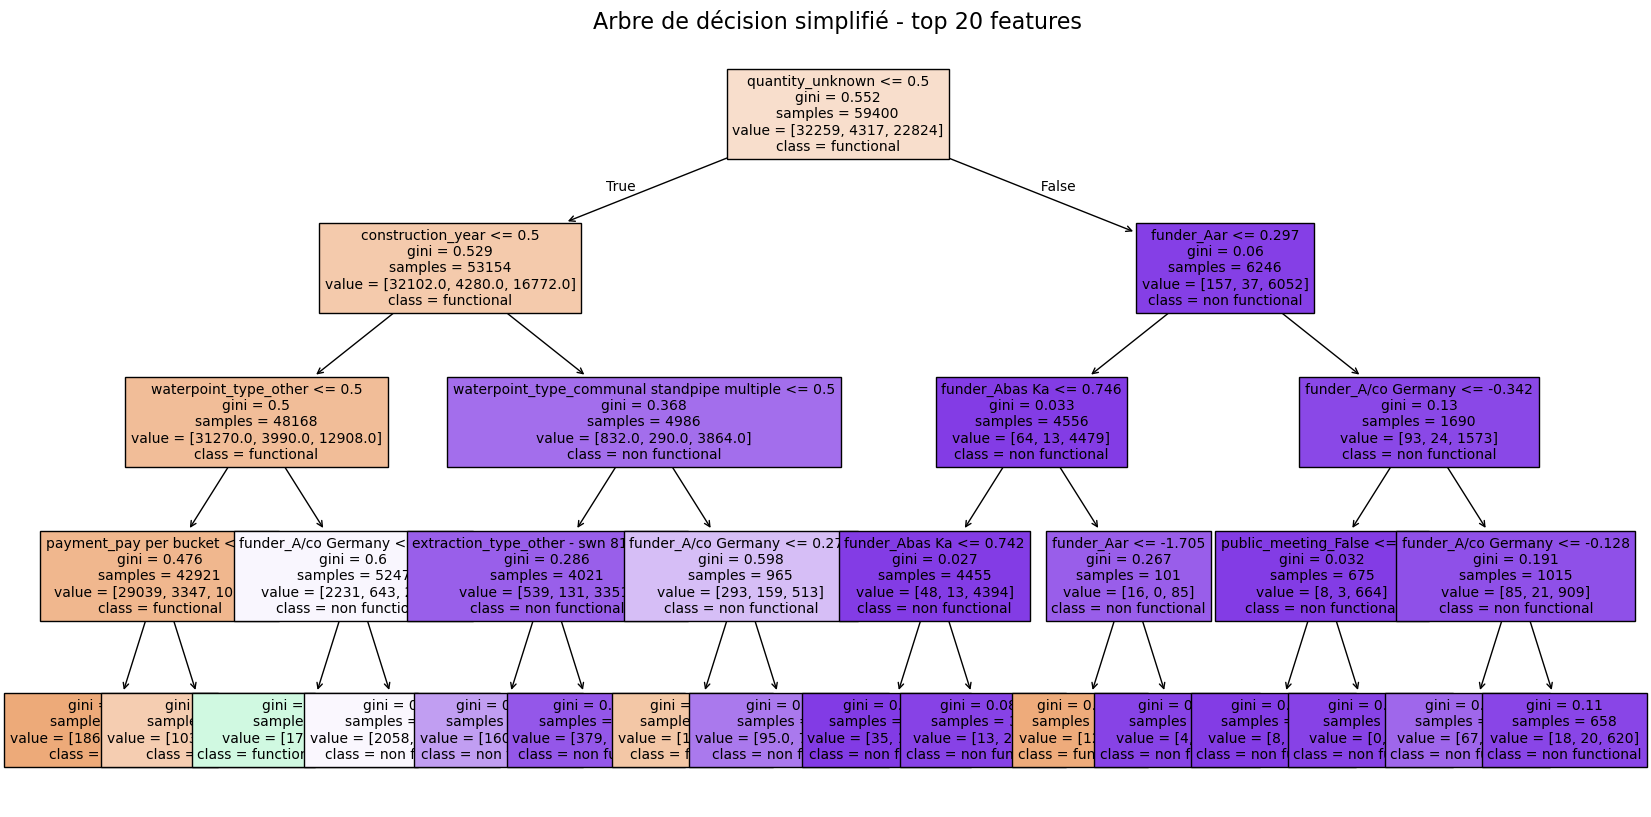

In [33]:
from sklearn.tree import plot_tree
# Top 20 indices
indices = np.argsort(dt.feature_importances_)[-20:]

# Sous-matrice pour visualisation
X_train_small = X_train_final[:, indices]

# Noms des colonnes correspondantes
top_features = [all_columns[i] for i in indices]

# Petit arbre
dt_small = DecisionTreeClassifier(max_depth=4, random_state=42)
dt_small.fit(X_train_small, y_train)

# Visualisation
plt.figure(figsize=(20,10))
plot_tree(dt_small, feature_names=top_features, class_names=classes, filled=True, fontsize=10)
plt.title("Arbre de décision simplifié - top 20 features", fontsize=16)
plt.show()

## barplot des importances de variables

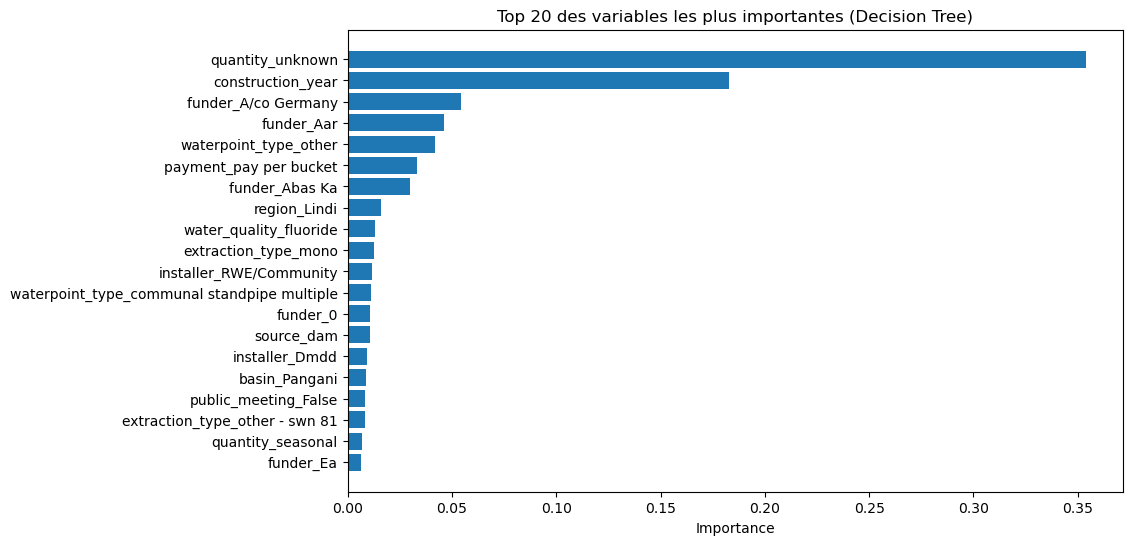

In [34]:
# Récupérer les importances de variables
importances = dt.feature_importances_

# Trier les 20 plus importantes
indices = np.argsort(importances)[-20:]
top_features = [all_columns[i] for i in indices]
top_importances = importances[indices]

# Tracer un barplot
plt.figure(figsize=(10,6))
plt.barh(range(len(indices)), top_importances, align="center")
plt.yticks(range(len(indices)), top_features)
plt.xlabel("Importance")
plt.title("Top 20 des variables les plus importantes (Decision Tree)")
plt.show()

## Lecture de l’arbre

- La racine (première décision) se fait sur quantity_unknown et construction_year, ce qui signifie que :

  - l’année de construction et

  - la connaissance/absence de donnée sur la quantité d’eau sont des variables clés pour différencier l’état des points d’eau.

- Ensuite, d’autres variables apparaissent :

  - type de point d’eau (waterpoint_type)

  - financeur (funder)

  - méthode d’extraction (extraction_type)

  - paiement (payment)

  - et des variables socio-organisationnelles comme public_meeting.

- Interprétation

  - Les nœuds orangés tendent vers la classe “functional”,

  - Les nœuds violets vers “non functional”,

  - Les transitions montrent des règles assez claires, par exemple :

  - Points d’eau récents + certains financeurs → souvent fonctionnels

  - Points d’eau anciens / type communal standpipe multiple → plus souvent non fonctionnels

  - Financeurs spécifiques (ex : A/co Germany, Abas Ka) influencent aussi la prédiction.
 
- Conclusion

  - Cet arbre montre de manière interprétable quelles caractéristiques structurent la décision.

  - Les variables liées à l’âge de l’infrastructure et au financeur semblent jouer un rôle majeur.

  - Par contre, la classe intermédiaire (“needs repair”) reste peu visible, confirmant la difficulté déjà observée avec la régression logistique.

## Comparaison des deux approches

- Régression logistique : donne de bons résultats globaux, surtout pour distinguer functional et non functional, mais elle prédit mal la classe intermédiaire (needs repair), car la frontière linéaire est trop simple.

- Arbre de décision : capture mieux certaines règles logiques (ex. construction_year, funder), mais reste limité seul et a tendance à surapprendre.

- Conclusion : sur les résultats, la régression logistique est globalement plus robuste et généralisable, tandis que l’arbre apporte de l’interprétabilité mais pas une nette amélioration de performance.

## Business Recommendation 1

## Prioriser les réparations préventives

- Les deux modèles montrent une bonne capacité à distinguer les pompes "non fonctionnelles".

- Cela signifie qu’on peut détecter à l’avance les infrastructures à haut risque de panne (par ex. certaines localisations, absence d’entretien, année de construction ancienne).

  
- Action : planifier des interventions préventives avant la panne totale, ce qui coûte moins cher qu’une réparation complète et garantit l’accès continu à l’eau.

### Business Recommendation 2

## Allouer les ressources selon les zones à risque

- L’arbre de décision a mis en avant des variables clés comme latitude, longitude et année de construction.

- Cela signifie que certaines régions ou infrastructures anciennes sont plus vulnérables.

- Action : concentrer les budgets et techniciens dans ces zones prioritaires plutôt que de répartir les ressources de manière uniforme.

### Business Recommendation 3

## Utiliser le modèle comme outil d’aide à la décision

- La régression logistique est plus stable et généralisable, tandis que l’arbre est plus interprétable (on voit facilement les règles de décision).

- En combinant les deux, on obtient un bon équilibre entre précision et compréhension.

- Action : déployer le modèle comme un tableau de bord de suivi pour les décideurs, afin d’identifier rapidement les pompes à risque et justifier les interventions auprès des communautés.

## Conclusion

L’analyse montre que la régression logistique offre une meilleure performance globale, tandis que l’arbre de décision apporte une interprétation claire des facteurs de défaillance.
En combinant ces résultats, les parties prenantes peuvent anticiper les pannes, prioriser les zones à risque et optimiser l’allocation des ressources, garantissant ainsi une meilleure durabilité et accessibilité des points d’eau.